In [2]:
import numpy as np # scientific computing
import pandas as pd # data loading and processing
import os # os operations
import matplotlib.pyplot as plt # for generating figures
import math
import matplotlib.dates as mdates
import seaborn as sns # for generating visualizations, better support with pandas than matplotlib
from scipy import stats

In [ ]:
# get names of nrf2 target genes
nrf2_names = pd.read_csv("./data/nrf2 target genes.csv", index_col=None, header= None).T
nrf2_names = nrf2_names.loc[0].to_list()

ox_stress = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
ox_stress = gene_set['Review'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  nrf2_names))

In [ ]:
# original

# get names of nrf2 target genes
nrf2_names = pd.read_csv("./data/nrf2 target genes.csv", index_col=None, header= None).T
nrf2_names = nrf2_names.loc[0].to_list()

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['Review'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  nrf2_names))

rval1 =[]
rval2 = []
cancer = ["COADREAD", "HNSC", "KIRC", "LUAD", "LIHC", "LUSC", "OV", "BRCA"] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig.suptitle('RRM2B expression against NRF2 activity in TCGA data',fontsize = 25)

fig1, axs1 = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig1.suptitle('RRM2B expression against G6PD expression in TCGA data',fontsize = 25)

for c in cancer:
    # construct the file name
    # n1 = "TCGA." + c + ".sampleMap_HiSeqV2"
    # n2 = "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"

    n1 = "./data/" + c+"_data_mrna_seq_v2_rsem.txt"
    n2 = "./data/" + c + "_data_clinical_sample.txt"

    # get expression data
    df = pd.read_csv(n1, index_col = 0, sep = "\t").drop(["Entrez_Gene_Id"], axis=1) # gene x patient

    # get phenotypes of samples
    pheno = pd.read_csv(n2, index_col=1,header = 4, sep = "\t")
    pheno = pheno[["SAMPLE_TYPE"]]
    pheno_filtered = pheno.dropna()

    # subset to get relevant genes
    df_filtered = df.loc[targets]
    print(df_filtered.isnull().values.any())

    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)
    
    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    print(df_filtered.isnull().values.any())
    df_filtered = df_filtered.T # patients x genes

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=((df_filtered-df_filtered.median())/df_filtered.std())+1

    # add sample type labels
    data = pd.concat([df_filtered, pheno_filtered], axis = 1, join='inner')

    # take only nrf2 target genes
    nrf2 = data[nrf2_names]
    data.drop(nrf2_names, inplace = True, axis = 1)
    nrf2["NFE2L2"] = nrf2.mean(axis = 1)
    data = pd.concat([data, nrf2], axis = 1) # patients x genes 
    
    #find line of best fit
    y, x = data["NFE2L2"].to_numpy(), data["RRM2B"].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data["RRM2B"].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["RRM2B levels"] = pd.cut(data["RRM2B"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval1.append(r)


    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # plot the data

    # scatter plot for RRM2B against NRF2 activity
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="RRM2B", y="NFE2L2", hue= "SAMPLE_TYPE", ax= axs[cancer.index(c)])
    axs[cancer.index(c)].plot(x, a*x+b, color="black")
    axs[cancer.index(c)].set_ylabel("NRF2 activity (based on 53 genes)",fontsize = 18)
    axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    axs[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure 
    fig.savefig("RRM2B vs NRF2 53 cbio.png")

    #find line of best fit for G6PD against RRM2B
    y, x = data["G6PD"].to_numpy(), data["RRM2B"].to_numpy()
    a, b = np.polyfit(x, y, 1)

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval2.append(r)

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # scatter plot for G6PD against RRM2B
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="RRM2B", y="G6PD", hue= "SAMPLE_TYPE", ax= axs1[cancer.index(c)])
    axs1[cancer.index(c)].plot(x, a*x+b, color="black")
    axs1[cancer.index(c)].set_ylabel("G6PD expression",fontsize = 18)
    axs1[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    axs1[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs1[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure
    fig1.savefig("RRM2B vs G6PD cbio.png")

    # filter top and botton 25% of patients
    data["RRM2B levels"] = data["RRM2B levels"].cat.remove_categories("-")
    top = data[data["RRM2B levels"] == "Top 25%"]["NFE2L2"]
    bottom = data[data["RRM2B levels"] == "Bottom 25%"]["NFE2L2"]

    out = stats.ttest_ind(top, bottom)
    print(out)
 
    # box plot
    fig2, axs2 = plt.subplots()
    fig2.suptitle(c + " (p: " + str(round(out.pvalue,4)) + ")")
    sns.set_style("whitegrid")
    sns.set()
    sns.boxplot(data=data, x="RRM2B levels", y="NFE2L2", color="green", ax= axs2, notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"})
    axs2.set_ylabel("NRF2 activity (based on 53 genes)")
    # axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=20,fontsize = 15)
    plt.show()

    # save the figure
    fig2.savefig(c+"boxplot cbio.png")






# Xena

## NRF2

In [ ]:
# xena

# get names of target genes

# gene_set = pd.read_csv("./data/nrf2 target genes.csv", index_col=None, header= None).T
# gene_set = gene_set.loc[0].to_list()

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['NRF2 v3'].dropna().tolist()
targets = list(set(["G6PD", "RRM2B"] +  gene_set))

rval1 =[]
rval2 = []
cancer = ["COADREAD", "HNSC", "KIRC", "LUAD", "LIHC", "LUSC", "OV", "BRCA"] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig.suptitle('[XENA] RRM2B vs NRF2 (only GSTA4)',fontsize = 25)

# fig1, axs1 = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
# fig1.suptitle('RRM2B expression against G6PD expression in TCGA data',fontsize = 25)

for c in cancer:
    # construct the file name
    n1 = "./data/" + "TCGA." + c + ".sampleMap_HiSeqV2"
    n2 = "./data/" + "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"

    # get expression data
    df = pd.read_csv(n1, index_col = 0, sep = "\t") # gene x patient

    # get phenotypes of samples
    pheno = pd.read_csv(n2, index_col=0, sep = "\t")
    pheno = pheno[["sample_type"]]
    pheno_filtered = pheno.dropna()

    # subset to get relevant genes
    df_filtered = df.loc[targets]
    print(df_filtered.isnull().values.any())
    
    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)
    
    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
        print(df_filtered.isnull().values.any())
    df_filtered = df_filtered.T # patients x genes

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=((df_filtered-df_filtered.median())/df_filtered.std())+1

    # add sample type labels
    data = pd.concat([df_filtered, pheno_filtered], axis = 1, join='inner')

    # take the mean across nrf2 target genes to get nrf2 activity 
    nrf2 = data[gene_set]
    data.drop(gene_set, inplace = True, axis = 1)
    nrf2["NFE2L2"] = nrf2.mean(axis = 1)
    data = pd.concat([data, nrf2], axis = 1) # patients x genes 
    
    #find line of best fit
    y, x = data["NFE2L2"].to_numpy(), data["RRM2B"].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data["RRM2B"].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["RRM2B levels"] = pd.cut(data["RRM2B"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval1.append(r)


    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # plot the data

    # scatter plot for RRM2B against NRF2 activity
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="RRM2B", y="NFE2L2", color = "green", ax= axs[cancer.index(c)])
    axs[cancer.index(c)].plot(x, a*x+b, color="black")
    axs[cancer.index(c)].set_ylabel("NRF2 activity",fontsize = 18)
    axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    axs[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure 
    fig.savefig("RRM2B vs nrf2 v3 xena.png")

    # #find line of best fit for G6PD against RRM2B
    # y, x = data["G6PD"].to_numpy(), data["RRM2B"].to_numpy()
    # a, b = np.polyfit(x, y, 1)

    # # get r sq val
    # r = np.corrcoef(x, y)[0, 1]
    # rval2.append(r)

    # #find p-value
    # n = data.shape[0]
    # t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    # p = stats.t.sf(abs(t), df=n)*2

    # # scatter plot for G6PD against RRM2B
    # sns.set_style("whitegrid")
    # sns.set()
    # sns.scatterplot(data=data, x="RRM2B", y="G6PD", hue= "sample_type", ax= axs1[cancer.index(c)])
    # axs1[cancer.index(c)].plot(x, a*x+b, color="black")
    # axs1[cancer.index(c)].set_ylabel("G6PD expression",fontsize = 18)
    # axs1[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    # axs1[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    # axs1[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    # plt.show()

    # # save the figure
    # fig1.savefig("RRM2B vs G6PD xena.png")

    # # filter top and botton 25% of patients
    # data["RRM2B levels"] = data["RRM2B levels"].cat.remove_categories("-")
    # top = data[data["RRM2B levels"] == "Top 25%"]["NFE2L2"]
    # bottom = data[data["RRM2B levels"] == "Bottom 25%"]["NFE2L2"]

    # out = stats.ttest_ind(top, bottom)
    # print(out)
 
    # # box plot
    # fig2, axs2 = plt.subplots()
    # fig2.suptitle(c + " (p: " + str(round(out.pvalue,4)) + ")")
    # sns.set_style("whitegrid")
    # sns.set()
    # sns.boxplot(data=data, x="RRM2B levels", y="NFE2L2", color="green", ax= axs2, notch=True, showcaps=False,
    # flierprops={"marker": "x"},
    # boxprops={"facecolor": (.4, .6, .8, .5)},
    # medianprops={"color": "coral"})
    # axs2.set_ylabel("NRF2 activity (based on 53 genes)")
    # # axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=20,fontsize = 15)
    # plt.show()

    # # save the figure
    # fig2.savefig(c+"boxplot xena.png")






## Oxidative stress signature

In [ ]:
# xena

# get gene names of oxidative stress signature
# nrf2_names = pd.read_csv("./data/nrf2 target genes.csv", index_col=None, header= None).T
# nrf2_names = nrf2_names.loc[0].to_list()

ox_stress = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
ox_stress = ox_stress['Review v3'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  ox_stress))

rval1 =[]
rval2 = []
cancer = ["COADREAD", "HNSC", "KIRC", "LUAD", "LIHC", "LUSC", "OV", "BRCA"] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig.suptitle('[XENA] RRM2B vs Oxidative stress (only GSTA4) ',fontsize = 25)

# fig1, axs1 = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
# fig1.suptitle('RRM2B expression against G6PD expression in TCGA data',fontsize = 25)

for c in cancer:
    # construct the file name
    n1 = "./data/" + "TCGA." + c + ".sampleMap_HiSeqV2"
    n2 = "./data/" + "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"

    # get expression data
    df = pd.read_csv(n1, index_col = 0, sep = "\t") # gene x patient

    # get phenotypes of samples
    pheno = pd.read_csv(n2, index_col=0, sep = "\t")
    pheno = pheno[["sample_type"]]
    pheno_filtered = pheno.dropna()

    # subset to get relevant genes
    df_filtered = df.loc[targets]
    print(df_filtered.isnull().values.any())
    
    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)
    
    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
        print(df_filtered.isnull().values.any())
    df_filtered = df_filtered.T # patients x genes

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=((df_filtered-df_filtered.median())/df_filtered.std())+1

    # add sample type labels
    data = pd.concat([df_filtered, pheno_filtered], axis = 1, join='inner')

    # take the mean across nrf2 target genes to get nrf2 activity
    nrf2 = data[ox_stress]
    data.drop(ox_stress, inplace = True, axis = 1)
    nrf2["NFE2L2"] = nrf2.mean(axis = 1)
    data = pd.concat([data, nrf2], axis = 1) # patients x genes 
    
    #find line of best fit
    y, x = data["NFE2L2"].to_numpy(), data["RRM2B"].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data["RRM2B"].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["RRM2B levels"] = pd.cut(data["RRM2B"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval1.append(r)


    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # plot the data

    # scatter plot for RRM2B against NRF2 activity
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="RRM2B", y="NFE2L2", color = "green", ax= axs[cancer.index(c)])
    axs[cancer.index(c)].plot(x, a*x+b, color="black")
    axs[cancer.index(c)].set_ylabel("Oxidative stress",fontsize = 18)
    axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    axs[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure 
    fig.savefig("RRM2B vs Oxidative stress v3 xena.png")

    # #find line of best fit for G6PD against RRM2B
    # y, x = data["G6PD"].to_numpy(), data["RRM2B"].to_numpy()
    # a, b = np.polyfit(x, y, 1)

    # # get r sq val
    # r = np.corrcoef(x, y)[0, 1]
    # rval2.append(r)

    # #find p-value
    # n = data.shape[0]
    # t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    # p = stats.t.sf(abs(t), df=n)*2

    # # scatter plot for G6PD against RRM2B
    # sns.set_style("whitegrid")
    # sns.set()
    # sns.scatterplot(data=data, x="RRM2B", y="G6PD", hue= "sample_type", ax= axs1[cancer.index(c)])
    # axs1[cancer.index(c)].plot(x, a*x+b, color="black")
    # axs1[cancer.index(c)].set_ylabel("G6PD expression",fontsize = 18)
    # axs1[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    # axs1[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    # axs1[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    # plt.show()

    # # save the figure
    # fig1.savefig("RRM2B vs G6PD xena.png")

    # # filter top and botton 25% of patients
    # data["RRM2B levels"] = data["RRM2B levels"].cat.remove_categories("-")
    # top = data[data["RRM2B levels"] == "Top 25%"]["NFE2L2"]
    # bottom = data[data["RRM2B levels"] == "Bottom 25%"]["NFE2L2"]

    # out = stats.ttest_ind(top, bottom)
    # print(out)
 
    # # box plot
    # fig2, axs2 = plt.subplots()
    # fig2.suptitle(c + " (p: " + str(round(out.pvalue,4)) + ")")
    # sns.set_style("whitegrid")
    # sns.set()
    # sns.boxplot(data=data, x="RRM2B levels", y="NFE2L2", color="green", ax= axs2, notch=True, showcaps=False,
    # flierprops={"marker": "x"},
    # boxprops={"facecolor": (.4, .6, .8, .5)},
    # medianprops={"color": "coral"})
    # axs2.set_ylabel("NRF2 activity (based on 53 genes)")
    # # axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=20,fontsize = 15)
    # plt.show()

    # # save the figure
    # fig2.savefig(c+"boxplot xena.png")






# Cbio

## NRF2

In [ ]:
# review paper
# ox stress

# get names of target genes
# gene_set = pd.read_csv("./data/nrf2 target genes.csv", index_col=None, header= None).T
# gene_set = nrf2_names.loc[0].to_list()

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['NRF2 v3'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

rval1 =[]
rval2 = []
cancer =  ["COADREAD", "HNSC", "KIRC", "LUAD", "LIHC", "LUSC", "OV", "BRCA"] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig.suptitle('[CBio] RRM2B vs NRF2 (only GSTA4)',fontsize = 25)

# fig1, axs1 = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
# fig1.suptitle('RRM2B expression against G6PD expression in TCGA data',fontsize = 25)

for c in cancer:
    n1 = "./data/" + c+"_data_mrna_seq_v2_rsem.txt"
    n2 = "./data/" + c + "_data_clinical_sample.txt"

    # get expression data
    df = pd.read_csv(n1, index_col = 0, sep = "\t").drop(["Entrez_Gene_Id"], axis=1) # gene x patient

    # subset to get relevant genes
    df_filtered = df.loc[targets]

    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)

    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    df_filtered = df_filtered.T # patients x genes

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    data=((df_filtered-df_filtered.mean())/df_filtered.std())+1

    # take mean across NRF2 target genes
    oxstress = data[gene_set]
    data.drop(gene_set, inplace = True, axis = 1)
    oxstress["os"] = oxstress.mean(axis = 1) # mean is horizontal
    data = pd.concat([data, oxstress], axis = 1) # patients x genes 
    data.head()

    #find line of best fit
    y, x = data["os"].to_numpy(), data["RRM2B"].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data["os"].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["os levels"] = pd.cut(data["os"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval1.append(r)

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # plot the data

    # scatter plot for RRM2B against os
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="RRM2B", y="os", color = "green", ax= axs[cancer.index(c)])
    axs[cancer.index(c)].plot(x, a*x+b, color="black")
    axs[cancer.index(c)].set_ylabel("NRF2 activity",fontsize = 18)
    axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    axs[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure 
    fig.savefig("RRM2B vs NRF2 activity v3 cbio.png")

    # #find line of best fit for G6PD against RRM2B
    # y, x = data["G6PD"].to_numpy(), data["RRM2B"].to_numpy()
    # a, b = np.polyfit(x, y, 1)

    # # get r sq val
    # r = np.corrcoef(x, y)[0, 1]
    # rval2.append(r)

    # #find p-value
    # n = data.shape[0]
    # t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    # p = stats.t.sf(abs(t), df=n)*2

    # # scatter plot for G6PD against RRM2B
    # sns.set_style("whitegrid")
    # sns.set()
    # sns.scatterplot(data=data, x="RRM2B", y="G6PD", hue= "SAMPLE_TYPE", ax= axs1[cancer.index(c)])
    # axs1[cancer.index(c)].plot(x, a*x+b, color="black")
    # axs1[cancer.index(c)].set_ylabel("G6PD expression",fontsize = 18)
    # axs1[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    # axs1[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    # axs1[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    # plt.show()

    # # save the figure
    # fig1.savefig("RRM2B vs G6PD.png")

    # # filter top and botton 25% of patients
    # data["os levels"] = data["os levels"].cat.remove_categories("-")
    # top = data[data["os levels"] == "Top 25%"]["os"]
    # bottom = data[data["os levels"] == "Bottom 25%"]["os"]

    # out = stats.ttest_ind(top, bottom)
    # print(out)
 
    # # box plot
    # fig2, axs2 = plt.subplots()
    # fig2.suptitle(c + " (p: " + str(round(out.pvalue,4)) + ")")
    # sns.set_style("whitegrid")
    # sns.set()
    # sns.boxplot(data=data, x="RRM2B levels", y="os", ax= axs2, notch=True, showcaps=False,
    # flierprops={"marker": "x"},
    # boxprops={"facecolor": (.4, .6, .8, .5)},
    # medianprops={"color": "coral"})
    # axs2.set_ylabel("Oxidative stress")
    # # axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=20,fontsize = 15)
    # plt.show()

    # # save the figure
    # fig2.savefig(c+"boxplot oxidative stress.png")






## Oxidative stress signature

In [ ]:
# review paper
# nrf2 

# get names of ox_stress target genes
nrf2_names = pd.read_csv("./data/nrf2 target genes.csv", index_col=None, header= None).T
nrf2_names = nrf2_names.loc[0].to_list()

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['Review v3'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

rval1 =[]
rval2 = []
cancer = ["COADREAD", "HNSC", "KIRC", "LUAD", "LIHC", "LUSC", "OV", "BRCA"] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig.suptitle('[Cbio] RRM2B vs oxidative stress signature (only GSTA4)',fontsize = 25)

# fig1, axs1 = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
# fig1.suptitle('RRM2B expression against G6PD expression in TCGA data',fontsize = 25)

for c in cancer:
    n1 = "./data/" + c+"_data_mrna_seq_v2_rsem.txt"
    n2 = "./data/" + c + "_data_clinical_sample.txt"

    # get expression data
    df = pd.read_csv(n1, index_col = 0, sep = "\t").drop(["Entrez_Gene_Id"], axis=1) # gene x patient

    # subset to get relevant genes
    df_filtered = df.loc[targets]

    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)

    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    df_filtered = df_filtered.T # patients x genes

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    data=((df_filtered-df_filtered.mean())/df_filtered.std())+1

    # take only nrf2 oxstress target genes
    oxstress = data[ox_stress]
    data.drop(ox_stress, inplace = True, axis = 1)
    oxstress["os"] = oxstress.mean(axis = 1) # mean is horizontal
    print(oxstress.shape)
    data = pd.concat([data, oxstress], axis = 1) # patients x genes 
    data.head()

    #find line of best fit
    y, x = data["os"].to_numpy(), data["RRM2B"].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data["os"].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["os levels"] = pd.cut(data["os"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval1.append(r)

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # plot the data

    # scatter plot for RRM2B against os
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="RRM2B", y="os", color= "green", ax= axs[cancer.index(c)])
    axs[cancer.index(c)].plot(x, a*x+b, color="black")
    axs[cancer.index(c)].set_ylabel("Oxidative stress",fontsize = 18)
    axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    axs[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure 
    fig.savefig("RRM2B vs oxidative stress v3 cbio.png")

    # #find line of best fit for G6PD against RRM2B
    # y, x = data["G6PD"].to_numpy(), data["RRM2B"].to_numpy()
    # a, b = np.polyfit(x, y, 1)

    # # get r sq val
    # r = np.corrcoef(x, y)[0, 1]
    # rval2.append(r)

    # #find p-value
    # n = data.shape[0]
    # t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    # p = stats.t.sf(abs(t), df=n)*2

    # # scatter plot for G6PD against RRM2B
    # sns.set_style("whitegrid")
    # sns.set()
    # sns.scatterplot(data=data, x="RRM2B", y="G6PD", hue= "SAMPLE_TYPE", ax= axs1[cancer.index(c)])
    # axs1[cancer.index(c)].plot(x, a*x+b, color="black")
    # axs1[cancer.index(c)].set_ylabel("G6PD expression",fontsize = 18)
    # axs1[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    # axs1[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    # axs1[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    # plt.show()

    # # save the figure
    # fig1.savefig("RRM2B vs G6PD.png")

    # # filter top and botton 25% of patients
    # data["os levels"] = data["os levels"].cat.remove_categories("-")
    # top = data[data["os levels"] == "Top 25%"]["os"]
    # bottom = data[data["os levels"] == "Bottom 25%"]["os"]

    # out = stats.ttest_ind(top, bottom)
    # print(out)
 
    # # box plot
    # fig2, axs2 = plt.subplots()
    # fig2.suptitle(c + " (p: " + str(round(out.pvalue,4)) + ")")
    # sns.set_style("whitegrid")
    # sns.set()
    # sns.boxplot(data=data, x="RRM2B levels", y="os", ax= axs2, notch=True, showcaps=False,
    # flierprops={"marker": "x"},
    # boxprops={"facecolor": (.4, .6, .8, .5)},
    # medianprops={"color": "coral"})
    # axs2.set_ylabel("Oxidative stress")
    # # axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=20,fontsize = 15)
    # plt.show()

    # # save the figure
    # fig2.savefig(c+"boxplot oxidative stress.png")






In [ ]:
# review paper
# nrf2 

# get names of ox_stress target genes
nrf2_names = pd.read_csv("./data/nrf2 target genes.csv", index_col=None, header= None).T
nrf2_names = nrf2_names.loc[0].to_list()

ox_stress = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
ox_stress = ox_stress['Before'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  ox_stress))

rval1 =[]
rval2 = []
cancer = ["COADREAD", "HNSC", "KIRC", "LUAD", "LIHC", "LUSC", "OV", "BRCA"] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig.suptitle('RRM2B expression against NRF2 activity (test) in TCGA data',fontsize = 25)

fig1, axs1 = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig1.suptitle('RRM2B expression against G6PD expression in TCGA data',fontsize = 25)

for c in cancer:
    print("----------------------------------")
    print(c)
    n1 = "./data/" + c+"_data_mrna_seq_v2_rsem.txt"
    n2 = "./data/" + c + "_data_clinical_sample.txt"

    # get expression data
    df = pd.read_csv(n1, index_col = 0, sep = "\t").drop(["Entrez_Gene_Id"], axis=1) # gene x patient

    # subset to get relevant genes
    df_filtered = df.loc[targets]

    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)

    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    df_filtered = df_filtered.T # patients x genes

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    data=((df_filtered-df_filtered.mean())/df_filtered.std())+1

    # take only nrf2 oxstress target genes
    oxstress = data[ox_stress]
    data.drop(ox_stress, inplace = True, axis = 1)
    oxstress["os"] = oxstress.mean(axis = 1) # mean is horizontal
    print(oxstress.shape)
    data = pd.concat([data, oxstress], axis = 1) # patients x genes 
    data.head()

    #find line of best fit
    y, x = data["os"].to_numpy(), data["RRM2B"].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data["os"].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["os levels"] = pd.cut(data["os"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval1.append(r)

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # plot the data

    # scatter plot for RRM2B against os
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="RRM2B", y="os", ax= axs[cancer.index(c)])
    axs[cancer.index(c)].plot(x, a*x+b, color="black")
    axs[cancer.index(c)].set_ylabel("NRF2 activity",fontsize = 18)
    axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    axs[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure 
    fig.savefig("RRM2B vs nrf2 test.png")

    

# P53

False
[]
False
[ 2.13452281  0.18533989  0.30849842  1.41894975  0.63981903  1.25076444
  0.07498124  1.40454446  1.21553843  0.84287007  0.80990113  1.85407058
  1.85813639  0.41673389  2.62986199  0.44017121  1.01002613 -0.72408352
  0.30315283  0.92824205 -1.08557212  0.79285593  1.78634437  1.65527685
  0.63456903  1.60897528  2.16469956  0.31881654  0.39821925  0.15655799
  1.69565246  1.81675871  1.95527812  0.61246636  0.02638473  2.10897555
 -0.06498777 -0.07928823  0.69331958  0.53253012  0.76860655  1.2621415
  0.61101608  2.76885248  1.29902466  0.88149736  0.83051366  1.53913093
  1.59660845  1.61034886  3.44953751  1.72792328  5.15617586  1.55446439
  0.76285385  1.63299807  1.1061005   2.0250712   1.14558742  0.15544295
  1.62510834  0.98819343  2.99107883  0.51941645  0.42204653  1.38839016
  1.65253631  0.63674162  1.58079426  0.08375229  1.83287995  1.29116479
  1.23973072  0.65230438  0.97255734  2.0554282  -0.74886066  1.94752566
  1.45101732  0.46906046  1.62202012 

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2428/1804828663.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p53["p53 exp"] = p53.mean(axis = 1)


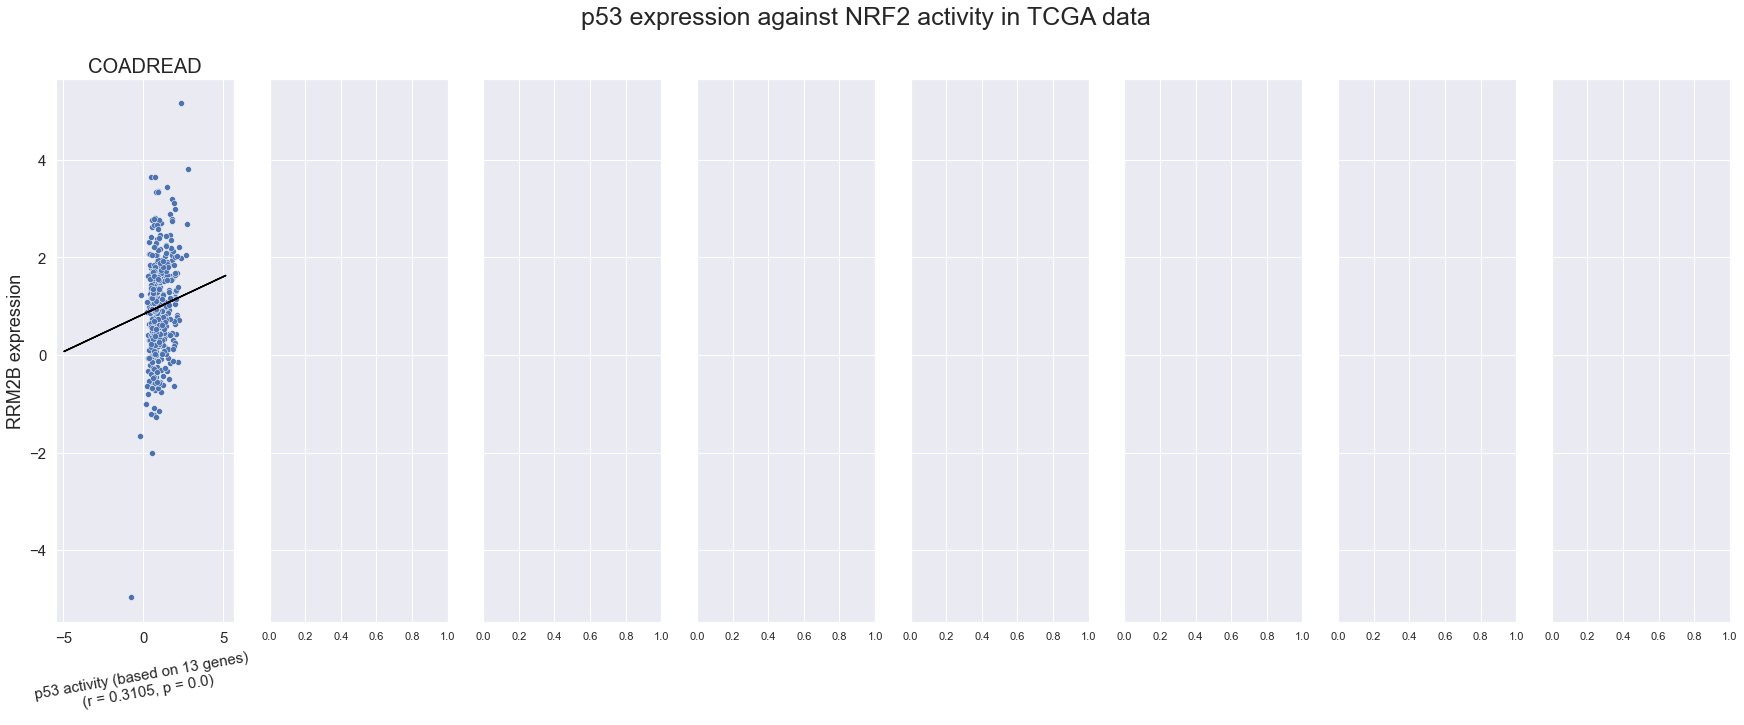

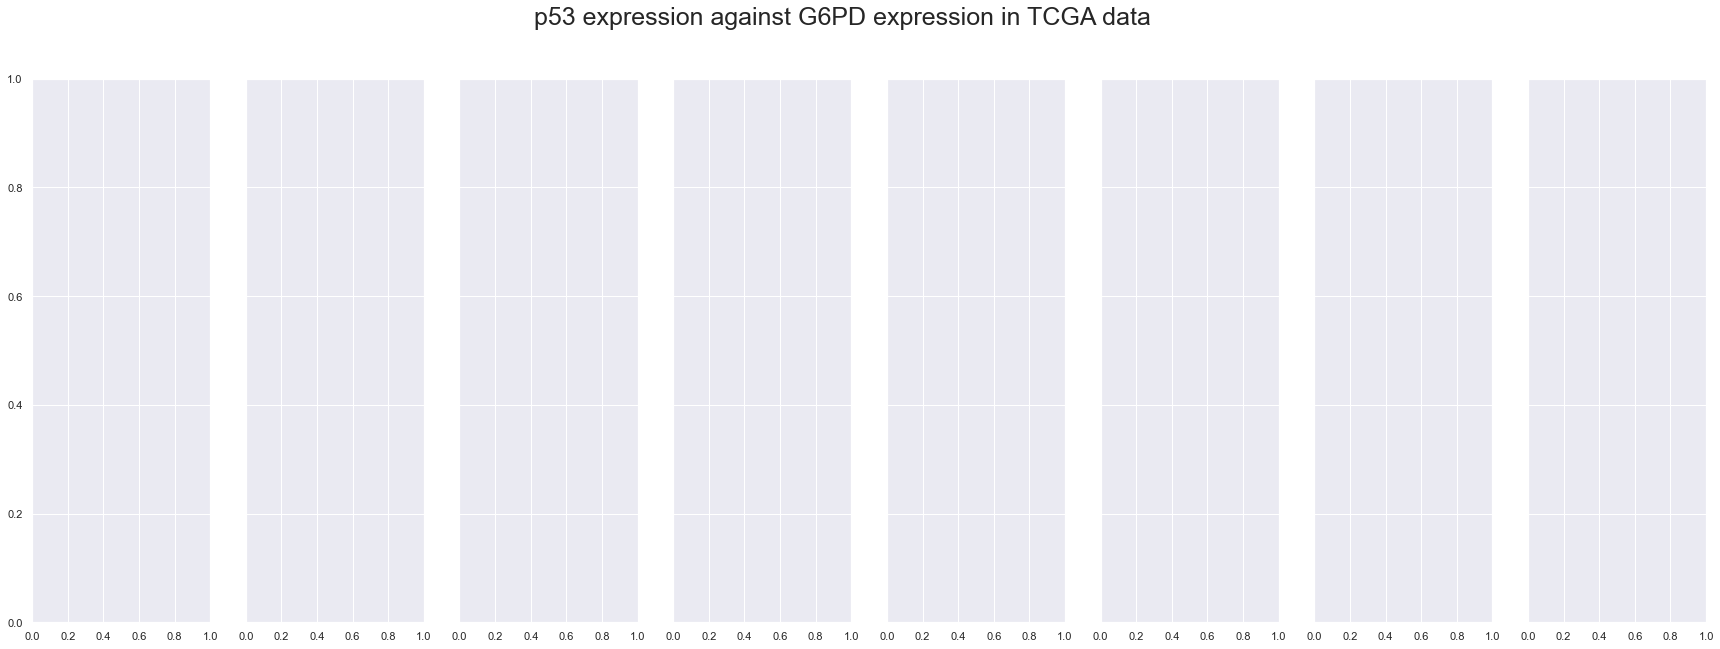

Ttest_indResult(statistic=35.46527752877939, pvalue=8.536229096411526e-92)


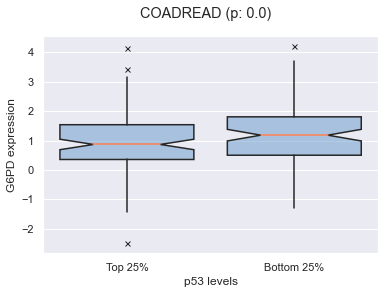

False
[]
False
[ 1.27948755e+00  1.70494105e-01  1.43070571e-01  1.79498744e+00
  9.28731569e-01  1.06156449e+00 -1.16475236e+00  2.28133602e+00
  7.35617465e-01  3.08443855e-01  9.51211005e-01  2.35941771e+00
  2.08677609e+00  9.71096234e-01  1.64755212e+00  2.72282280e+00
  2.62043700e+00  2.75599649e+00 -7.52173314e-02  1.62922388e+00
  9.09600333e-01  2.91974637e+00  1.51247070e+00 -1.06782662e+00
  2.34908685e+00  1.18259538e+00  2.42641367e+00 -9.83996646e-03
  1.45355435e+00  1.54765949e+00  6.38138456e-01  2.06231542e+00
  1.57380946e+00  5.72125088e-01  8.75786006e-01  9.24071346e-01
 -2.58422729e+00  5.26600006e-01  7.05684217e-01  6.94771329e-01
  1.35045936e+00  6.64928256e-01  1.05662212e+00 -1.27213152e+00
  9.67730232e-01 -3.65666436e-01  5.72125088e-01  6.57091767e-01
  1.52177888e+00  1.34998930e+00  1.74455781e+00  6.49088239e-01
  1.68291979e+00 -1.76509350e-01  1.13536702e+00  1.23442499e+00
  1.29317142e+00  1.31453994e+00  2.03932290e+00  1.46398471e+00
 -2.711664

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2428/1804828663.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p53["p53 exp"] = p53.mean(axis = 1)


Ttest_indResult(statistic=35.00560531240777, pvalue=1.8391337237491522e-104)


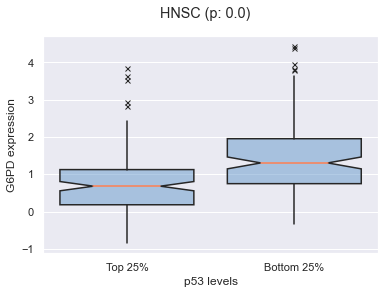

False
[]
False
[ 1.97180304e+00  5.68511171e-01  3.48442769e-03  8.18077972e-01
  6.41773999e-01  1.80565592e-01 -6.06729390e-01  7.89001799e-01
  5.84587659e-01  1.71714899e+00 -6.40377316e-01  1.80438438e+00
 -5.43048384e-01  1.18886123e+00  2.81835722e+00  9.18832374e-01
  2.39643171e-01  7.45475655e-01  2.03427590e+00  6.36830164e-01
  4.38042054e-01  1.41255775e-01  2.49399316e+00  1.27749643e+00
  2.03935395e+00  2.92469532e-01  1.34157179e+00  1.63422018e+00
  1.16680527e+00  1.39035175e+00  1.17675841e+00  6.10384947e-01
  1.67047419e+00 -3.43200950e-01  7.92215833e-01 -3.43200950e-01
  8.34118922e-01  1.88931269e+00  1.58003741e+00  4.15464848e-01
  4.00974096e-01  9.83257502e-01  6.59323016e-01  1.89059179e+00
  1.46353883e+00  2.79242250e+00  9.83927479e-01  1.22710976e+00
  1.38296868e+00 -2.88953118e-01 -1.28589016e+00  1.55109996e+00
  1.66028456e+00  1.84128549e+00  1.63810777e+00  1.80342080e+00
 -2.21488453e-01  8.51664428e-01  1.95603400e+00  1.98421816e+00
  3.698861

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2428/1804828663.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p53["p53 exp"] = p53.mean(axis = 1)


Ttest_indResult(statistic=39.937978951663396, pvalue=2.556812911914768e-122)


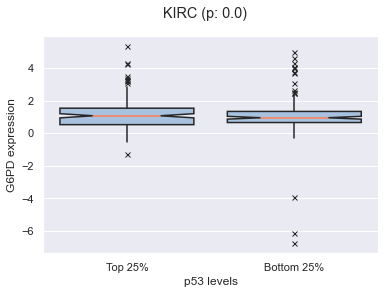

False
[]
False
[ 0.0410531  -0.39298181  1.3670866   1.73703713  2.0741741   1.21690113
  3.29667986  3.80310559  1.71891364 -0.51923421  3.06174231  0.14002061
  1.44834069  1.41030105 -0.29979655  0.94872537  3.16618622  2.22185836
  1.89469592  1.58753068  2.0590659  -0.22814005  1.0473242   0.45187833
  0.44124246  0.68750185  1.50481891  1.72589703  1.65066195  0.49391397
  0.17667629  1.29093155  1.34949231  1.27062533  2.12752722  1.09212808
  0.50451414  1.18593993  1.85506361  1.85919111  0.32009698  0.40695454
  0.80171844 -0.41282454  0.80385474 -0.70379831  0.47778214  2.30670014
  1.65322508  1.6441848   2.23655046  1.65754098  0.66395473  0.97466596
 -0.57589947  0.12396602  2.2433068   2.11207745  0.8496437   1.32444134
 -0.71744622  0.2094009   2.57466195  1.89097635  0.34607291  0.43424507
  1.09744003  1.62662908  0.65576237  0.76621332  0.65173648  2.13616197
  1.15380334 -0.13970875  1.69592708  2.08100086  1.17495692 -1.67607712
  0.0594332   1.16340949  0.41615399

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2428/1804828663.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p53["p53 exp"] = p53.mean(axis = 1)


Ttest_indResult(statistic=46.12942745470911, pvalue=3.19263611905228e-134)


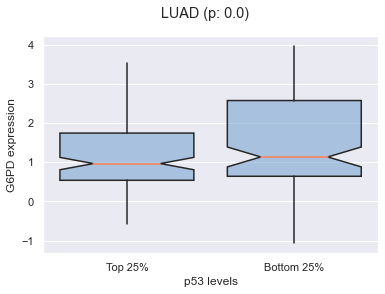

False
[]
False
[-1.01650227  1.47839884  1.07337301  1.16920926  1.33896114  1.57297459
  1.32339219  0.63495522  0.18955888  1.53682063  1.49784868  1.18581116
  2.25115966 -0.84202337  1.63204945  0.16906345  2.19558845  1.20151555
  1.69218545  0.06792072  4.40960755  1.77460839  1.72798772  1.11428476
  0.6712482  -1.0737926   1.05768932  2.87306237  0.55799526  0.07563905
  0.63480319  1.49640876  1.06908373  1.71819275  2.58540388  0.62141903
  1.04569416  1.49626477  1.71549452  0.5689906   1.72231021  0.81213865
  2.09079586  1.33357921  2.03243216  0.96132437  0.57738469  1.00148564
  1.39456444  0.2193942  -0.6249413   1.87840958  1.53322944  1.6887715
  0.71774582 -0.63976075  0.02911473  1.4612344   2.37371696 -0.62527047
  1.13182824 -1.60505332  0.12218445  0.38720413  1.83279809  2.48992582
  0.60802358  0.6145705   0.22610332  0.5486738   0.38071723  2.55822146
  0.46545544  1.75563656 -0.43337425 -0.27803148  2.40529694  1.31028498
  1.40586452  2.15985975  0.60330203 

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2428/1804828663.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p53["p53 exp"] = p53.mean(axis = 1)


Ttest_indResult(statistic=39.96106438968863, pvalue=7.923502124090681e-100)


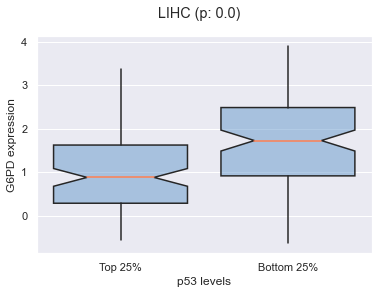

False
[]
False
[ 2.36958027e+00  1.34336343e+00  5.70795769e-01  1.03496884e+00
 -3.31292108e-01  2.33561502e+00 -1.04154180e+00 -3.28597308e-02
  2.29040194e+00  1.24452068e+00  9.99464270e-01  1.24980979e+00
  1.83731241e+00  1.22440887e+00 -5.79293414e-01  1.03372104e+00
  9.81955595e-01  3.80536348e+00  6.33503689e-01  1.97430783e+00
  3.21422673e-01  1.48041123e+00 -6.53657602e-01 -1.00941431e+00
  8.95609735e-01  1.34371428e+00  6.10012071e-01  8.94891554e-01
  4.21593520e-02  6.30045477e-01  2.44942935e+00  1.43611694e+00
  1.76501610e+00 -8.81436081e-01  9.99464270e-01 -3.05290546e-01
 -3.43157388e-01  1.78182943e+00  7.13959611e-01 -3.61543826e-01
  6.90747161e-01  4.07237867e-01  2.22380799e+00  1.18465295e+00
  9.98701984e-02  1.58221614e+00  4.26930744e-01  1.56800265e+00
 -1.05643376e+00  2.14924529e+00  1.05759346e+00  2.46780928e+00
  2.93189537e+00  6.54967153e-01 -7.86397597e-01 -2.59871870e-01
  3.65392920e-01 -1.14542876e+00  5.26193153e-01  1.00000000e+00
 -1.259567

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2428/1804828663.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p53["p53 exp"] = p53.mean(axis = 1)


Ttest_indResult(statistic=37.50776100792442, pvalue=6.25166610405042e-110)


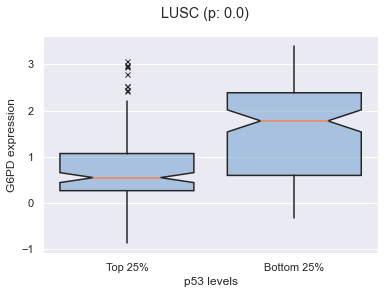

False
[]
False
[ 3.45929720e-01  1.48382073e+00  1.00058307e+00  1.28948617e-01
 -9.24339448e-01 -2.73890507e-01  2.33292764e+00  6.09945705e-02
  1.14539975e+00  7.34498890e-01  2.33755198e+00  6.70598732e-01
  2.12977564e+00  1.05447188e+00  1.27327379e+00  1.60816681e+00
 -1.14073363e-01  1.12655807e+00  2.07628774e-01  1.53718744e+00
  8.35877818e-01  1.97763106e+00  2.89249676e-01  1.62833558e+00
  1.46464232e-01  2.08849848e-01  3.31736796e-02  2.08682274e+00
  5.58498030e-01  5.00828769e-02  2.58057564e+00  3.10275975e+00
  7.80623644e-01  4.26381669e-01  3.89276425e+00  3.47596234e-02
  1.45772401e+00  1.79663494e+00  1.00674558e+00  3.93797372e-01
 -1.68428024e+00  1.41143063e+00  8.80222098e-01 -2.62233527e-01
  6.72975932e-01 -1.64498924e+00  1.01062003e-01  2.41551587e+00
  2.35372740e+00  2.13913294e+00  1.81729887e+00  1.73513221e+00
  1.28196168e+00  5.75581771e-01  2.20511315e+00  9.11061235e-01
  5.13486612e-01  1.97841796e+00  1.15274042e-01 -8.99177684e-02
  1.436298

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2428/1804828663.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p53["p53 exp"] = p53.mean(axis = 1)


Ttest_indResult(statistic=20.50873372125401, pvalue=1.6949566091726398e-45)


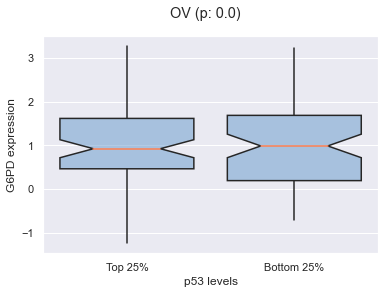

False
[]
False
[ 0.43353398  2.34087204 -0.18378101 ...  1.7379896   1.39162086
  2.15124148]


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2428/1804828663.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p53["p53 exp"] = p53.mean(axis = 1)


Ttest_indResult(statistic=62.79199424195907, pvalue=1.0895640430956185e-267)


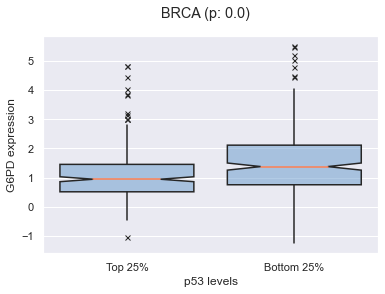

In [12]:
# original

# get names of p53 target genes
# gene_set = pd.read_csv("./data/nrf2 target genes.csv", index_col=None, header= None).T
# gene_set = gene_set.loc[0].to_list()

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0, sep = ",")
gene_set = gene_set['p53 new'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

rval1 =[]
rval2 = []
cancer = ["COADREAD", "HNSC", "KIRC", "LUAD", "LIHC", "LUSC", "OV", "BRCA"] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig.suptitle('p53 expression against NRF2 activity in TCGA data',fontsize = 25)

fig1, axs1 = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig1.suptitle('p53 expression against G6PD expression in TCGA data',fontsize = 25)

for c in cancer:
    # construct the file name
    # n1 = "TCGA." + c + ".sampleMap_HiSeqV2"
    # n2 = "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"

    n1 = "./data/" + "TCGA." + c + ".sampleMap_HiSeqV2"
    n2 = "./data/" + "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"

    # get expression data
    df = pd.read_csv(n1, index_col = 0, sep = "\t") # gene x patient

    # get phenotypes of samples
    pheno = pd.read_csv(n2, index_col=0, sep = "\t")
    pheno = pheno[["sample_type"]]
    pheno_filtered = pheno.dropna()

    # subset to get relevant genes
    df_filtered = df.loc[targets]
    print(df_filtered.isnull().values.any())

    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)
    
    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    print(df_filtered.isnull().values.any())
    df_filtered = df_filtered.T # patients x genes

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=((df_filtered-df_filtered.median())/df_filtered.std())+1

    # add sample type labels
    data = pd.concat([df_filtered, pheno_filtered], axis = 1, join='inner')

    # take only nrf2 target genes
    p53 = data[gene_set]
    data.drop(gene_set, inplace = True, axis = 1)
    p53["p53 exp"] = p53.mean(axis = 1)
    data = pd.concat([data, p53], axis = 1) # patients x genes 
    
    #find line of best fit
    y, x = data["p53 exp"].to_numpy(), data["RRM2B"].to_numpy()
    print(x)
    a, b = np.polyfit(x, y, 1)

    iqr = data["p53 exp"].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["p53 levels"] = pd.cut(data["p53 exp"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval1.append(r)


    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # plot the data

    # scatter plot for RRM2B against p53 activity
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="p53 exp", y="RRM2B", ax= axs[cancer.index(c)])
    axs[cancer.index(c)].plot(x, a*x+b, color="black")
    axs[cancer.index(c)].set_ylabel("RRM2B expression",fontsize = 18)
    axs[cancer.index(c)].set_xlabel("p53 activity (based on 13 genes)" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    axs[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure 
    fig.savefig("RRM2B vs p53 13 xena.png")

    #find line of best fit for G6PD against RRM2B
    y, x = data["G6PD"].to_numpy(), data["RRM2B"].to_numpy()
    a, b = np.polyfit(x, y, 1)

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval2.append(r)

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # scatter plot for G6PD against RRM2B
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="p53 exp", y="G6PD", ax= axs1[cancer.index(c)])
    axs1[cancer.index(c)].plot(x, a*x+b, color="black")
    axs1[cancer.index(c)].set_ylabel("G6PD expression",fontsize = 18)
    axs1[cancer.index(c)].set_xlabel("p53 expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    axs1[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs1[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure
    fig1.savefig("p53 exp vs G6PD xena.png")

    # filter top and botton 25% of patients
    data["p53 levels"] = data["p53 levels"].cat.remove_categories("-")
    top = data[data["p53 levels"] == "Top 25%"]["p53 exp"]
    bottom = data[data["p53 levels"] == "Bottom 25%"]["p53 exp"]

    out = stats.ttest_ind(top, bottom)
    print(out)
 
    # box plot
    fig2, axs2 = plt.subplots()
    fig2.suptitle(c + " (p: " + str(round(out.pvalue,4)) + ")")
    sns.set_style("whitegrid")
    sns.set()
    sns.boxplot(data=data, x="p53 levels", y="G6PD", color="green", ax= axs2, notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
    order=["Top 25%", "Bottom 25%"])
    axs2.set_ylabel("G6PD expression")
    # axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=20,fontsize = 15)
    plt.show()

    # save the figure
    fig2.savefig(c+"boxplot xena p53.png")




